In [6]:
from collections import defaultdict
from datetime import datetime, timedelta
from __future__ import division
import numpy as np

import os
import pytz


# Prepare Data

## Patient tweets data

In [7]:
def readPatient(folder, filename):
    with open(folder + filename, 'r') as openfile:
        return [line.strip().split('\t') for line in openfile.readlines()]
def checkFolderFile(folder):
    return os.listdir(folder)

In [8]:
folder = '../twitter crawler/patient_tweets/'
patient_list = checkFolderFile(folder)
patient_tweets_dict = defaultdict(lambda : [])
for patient_name in patient_list:
    patient_tweets_dict[patient_name] = readPatient(folder, patient_name)


## Patient Time zone

In [9]:
def readPatientTimezone(folder, filename):
    time_dict = {}
    with open(folder + filename, 'r') as openfile:
        for line in openfile.readlines():
            split = line.strip().split('\t')
            if split[2] != None:
                time_dict[split[1]] = split[2]
#             elif split[3]:
#                 time_dict[split[1][1:]] = split[3]
            else:
                continue
    return time_dict

In [10]:
patient_timezone_dict = readPatientTimezone('../twitter crawler/','bipolar_user_timezone')

In [11]:
timezone_location_dict = {
    'Pacific Time (US & Canada)':'US/Pacific',
    'Central Time (US & Canada)':'US/Central',
    'Eastern Time (US & Canada)':'US/Eastern',
    'London':'Europe/London',
    'Sydney':'Australia/Sydney',
    'Tokyo':'Asia/Tokyo',
    'Africa/Nairobi':'Africa/Nairobi',
    'Arizona':'US/Arizona',
    'Kyiv':'Europe/Simferopol',
    'Europe/London':'Europe/London',
    'Atlantic Time (Canada)':'Atlantic/Canary',
    'Midway Island':'Pacific/Apia',
    'Auckland':'Pacific/Auckland',
    'Amsterdam':'Europe/Amsterdam',
    'Baghdad':'Asia/Riyadh',
    'Riyadh':'Asia/Riyadh',
    'Belgrade':'Europe/Belgrade',
    'Quito':'Pacific/Galapagos',
    'Pretoria':'Africa/Johannesburg',
    'Beijing':'Asia/Shanghai',
    'Dublin':'Europe/Dublin',
    'Mountain Time (US & Canada)':'Mountain/US',
    'Hawaii':'Pacific/Honolulu',
    'Brisbane':'Australia/Brisbane',
    'Vienna':'Europe/Vienna',
    'Islamabad':'Asia/Karachi',
    'Casablanca':'Africa/Casablanca',
    'Yakutsk':'Asia/Yakutsk',
    'Tijuana':'America/Tijuana',
    'Africa/Johannesburg':'Africa/Johannesburg',
    'Mountain Time (US & Canada)':'US/Central'
    
}

In [12]:
def to_local_timezone(local, orig_time):
    dt = datetime.strptime(orig_time, "%Y-%m-%d %H:%M:%S")
    dt = pytz.timezone(local).localize(dt)
    est_dt = dt.astimezone(pytz.timezone('EST'))

#     print est_dt.strftime("%Y-%m-%d %H:%M:%S")
    return est_dt.strftime("%Y-%m-%d %H:%M:%S")

## To Daily Tweets

In [13]:
# patient_name -> date time -> tweets_time<\t>tweet
patient_day_tweets = defaultdict(lambda: defaultdict(lambda: []))
for patient in patient_tweets_dict:
    try:
        local = timezone_location_dict[patient_timezone_dict[patient]]
    except:
        continue
        
    for tweet in patient_tweets_dict[patient]:
        local_time = to_local_timezone(local,tweet[2])
        date, time = local_time.split(' ')
        date = int(date.replace('-',''))  
        try:
            patient_day_tweets[patient][date].append(local_time + '\t' +tweet[3])
        except:
            patient_day_tweets[patient][date].append(local_time + '\t<empty_tweets>')
patient_tweets_dict = None

In [23]:
len(patient_day_tweets)

228

In [24]:
len(patient_day_tweets['_raspberries'])

589

### Put on-tweets day back

In [14]:
def convertDatetime(orig_time):
    return datetime.strptime(str(orig_time), "%Y%m%d")

In [15]:
for patient in patient_day_tweets:
    sorted_date_user = sorted(patient_day_tweets[patient])
    last_date = None
    for date in sorted_date_user:
        # Check date change
        if last_date != None:
            date_diff = (convertDatetime(date) - convertDatetime(last_date)).days
            # If day difference > 1day
            # Append the gap, with date, frequence = 0, late = 0
            if date_diff > 1:
                for i in range(date_diff)[1:]:
                    temp_date = convertDatetime(last_date) + timedelta(days=i)
                    temp_date = temp_date.strftime("%Y%m%d")
                    patient_day_tweets[patient][int(temp_date)]=[]
        last_date = date

In [25]:
len(patient_day_tweets['_raspberries'])

589

# RulSIF

In [38]:
# RulSIF
from pylab import *
from scipy import linalg
from scipy.stats import norm

def compmedDist(X):
    size1=X.shape[0];
    Xmed = X;

    G = sum((Xmed*Xmed),1);
    Q = tile(G[:, newaxis],(1,size1));
    R = tile(G,(size1,1));

    dists = Q + R - 2*dot(Xmed,Xmed.T);
    dists = dists-tril(dists);
    dists= dists.reshape(size1**2,1,order='F').copy();
    return sqrt(0.5*median(dists[dists>0]));

def kernel_Gaussian(x, c, sigma):
    (d,nx) = x.shape
    (d,nc) = c.shape
    x2 = sum(x**2,0)
    c2 = sum(c**2, 0)

    distance2 = tile(c2,(nx,1)) + \
        tile(x2[:, newaxis],(1,nc)) \
        - 2* dot(x.T,c)
   
    return exp(-distance2/(2* (sigma**2)));

def R_ULSIF(x_nu, x_de, x_re, alpha, sigma_list,lambda_list, b, fold):
# x_nu: samples from numerator
# x_de: samples from denominator
# x_re: reference sample
# alpha: alpha defined in relative density ratio
# sigma_list, lambda_list: parameters for model selection
# b: number of kernel basis
# fold: number of fold for cross validation

    (d,n_nu) = x_nu.shape;
    (d,n_de) = x_de.shape;
    rand_index = permutation(n_nu);
    b = min(b,n_nu);
    #x_ce = x_nu[:,rand_index[0:b]]
    x_ce = x_nu[:,r_[0:b]]

    score_cv=zeros( (size(sigma_list), \
        size(lambda_list)));

    cv_index_nu = permutation(n_nu)
    #cv_index_nu = r_[0:n_nu]
    cv_split_nu=floor(r_[0:n_nu]*fold/n_nu)
    cv_index_de=permutation(n_de)
    #cv_index_de = r_[0:n_de]
    cv_split_de=floor(r_[0:n_de]*fold/n_de)

    for sigma_index in r_[0:size(sigma_list)]:
        sigma=sigma_list[sigma_index];
        K_de=kernel_Gaussian(x_de,x_ce,sigma).T;
        K_nu=kernel_Gaussian(x_nu,x_ce,sigma).T;

        score_tmp=zeros( (fold,size(lambda_list)));

        for k in r_[0:fold]:
            Ktmp1=K_de[:,cv_index_de[cv_split_de!=k]];
            Ktmp2=K_nu[:,cv_index_nu[cv_split_nu!=k]];
            
            Ktmp = alpha/Ktmp2.shape[1]*dot(Ktmp2,Ktmp2.T) + \
                (1-alpha)/Ktmp1.shape[1]*dot(Ktmp1, Ktmp1.T);
            
            mKtmp = mean(K_nu[:,cv_index_nu[cv_split_nu!=k]],1);
           
            for lambda_index in r_[0:size(lambda_list)]:
                
                lbd =lambda_list[lambda_index];
                
                thetat_cv= linalg.solve( Ktmp + lbd*eye(b), mKtmp);
                thetah_cv=thetat_cv;

                score_tmp[k,lambda_index]= alpha*mean(dot(K_nu[:,cv_index_nu[cv_split_nu==k]].T,thetah_cv)**2)/2. \
                    + (1-alpha)*mean(dot(K_de[:,cv_index_de[cv_split_de==k]].T, thetah_cv)**2)/2. \
                    - mean( dot(K_nu[:,cv_index_nu[cv_split_nu==k]].T, thetah_cv));

            score_cv[sigma_index,:]=mean(score_tmp,0);
    
    score_cv_tmp=score_cv.min(1);
    lambda_chosen_index = score_cv.argmin(1);

    score=score_cv_tmp.min();
    sigma_chosen_index = score_cv_tmp.argmin();

    lambda_chosen=lambda_list[lambda_chosen_index[sigma_chosen_index]];
    sigma_chosen=sigma_list[sigma_chosen_index];

    K_de=kernel_Gaussian(x_de,x_ce,sigma_chosen).T;
    K_nu=kernel_Gaussian(x_nu,x_ce,sigma_chosen).T;

    coe = alpha*dot(K_nu,K_nu.T)/n_nu + \
        (1-alpha)*dot(K_de,K_de.T)/n_de + \
        lambda_chosen*eye(b)
    var = mean(K_nu,1)
    
    thetat=linalg.solve(coe,var);
#    thetat=linalg.lstsq(coe,var)[0]
#    linalg.cho_factor(coe,overwrite_a=True)
#    linalg.cho_solve((coe,False), var, overwrite_b=True)
#    thetat = var
    
    #thetah=maximum(0,thetat)
    thetah = thetat;
    wh_x_de=dot(K_de.T,thetah).T;
    wh_x_nu=dot(K_nu.T,thetah).T;

    K_di=kernel_Gaussian(x_re,x_ce,sigma_chosen).T;
    wh_x_re=dot(K_di.T,thetah).T;

    wh_x_de[wh_x_de <0 ] = 0
    wh_x_re[wh_x_re <0] = 0;
    
    PE = mean(wh_x_nu) - 1./2*(alpha*mean(wh_x_nu**2) + \
        (1-alpha)*mean(wh_x_de**2)) - 1./2;

    return (PE,wh_x_re,score)

def sigma_list(x_nu,x_de):
    x = c_[x_nu, x_de];
    med = compmedDist(x.T);
    return med*array([0.6, 0.8, 1, 1.2, 1.4]);

def lambda_list():
    return 10.0**array([-3,-2,-1,0,1]);

def norm_pdf(x,mu,std):
    return exp(-(x-mu)**2/(2*(std**2)))/(std*sqrt(2*pi))

In [39]:
def cal_divergence(list1, list2, total):
    # x_nu = randn(1,5)*.25 - 1;
#     x_nu = np.random.randn(1,10)*.5;
#     x_de = np.random.randn(1,10)*.5;
#     x_re = array([arange(-1.5,1.5,.05)])

    x_nu = array([list1])
    x_de = array([list2])
    x_re = array([total])
    
    print(x_nu)
    print(x_de)
#     print(x_re)
    
#     x_re = np.array(total)

    #using normal ULSIF, which is RULSIF with alpha = 0.
    # x_nu: samples from numerator
    # x_de: samples from denominator
    # x_re: reference sample
    # alpha: alpha defined in relative density ratio
    # sigma_list, lambda_list: parameters for model selection
    # b: number of kernel basis
    # fold: number of fold for cross validation
    alpha = 0.1;
    (PE,w,s) = R_ULSIF(x_nu, x_de, c_[x_re,x_nu,x_de], alpha, sigma_list(x_nu,x_de),lambda_list(), 5, 5)

    print('divergence = ' + str(PE))
    return

[[  48.   78.   71.   77.  101.   81.  164.]]
[[  78.   71.   77.  101.   81.  164.   97.]]


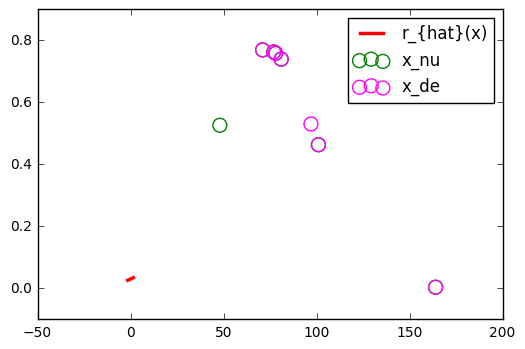

alpha =  0.1
divergence =  -0.124542325398


In [40]:
seed(3)
#generate data.

list1 = [48.0, 78.0, 71.0, 77.0, 101.0, 81.0, 164.0]
list2 = [78., 71., 77., 101., 81., 164., 97.]

# numerator samples
# x_nu = randn(1,5)*.25 - 1;
# x_nu = randn(1,10)*.5;
x_nu = array([list1])
# denominators samples
# x_de = randn(1,10)*.5;
x_de = array([list2])

x_re = array([arange(-1.5,1.5,.05)])

print x_nu
print x_de

# print x_nu    

#using normal ULSIF, which is RULSIF with alpha = 0.
# x_nu: samples from numerator
# x_de: samples from denominator
# x_re: reference sample
# alpha: alpha defined in relative density ratio
# sigma_list, lambda_list: parameters for model selection
# b: number of kernel basis
# fold: number of fold for cross validation
alpha = 0.1;
(PE,w,s) = R_ULSIF(x_nu, x_de, c_[x_re,x_nu,x_de], alpha, sigma_list(x_nu,x_de),lambda_list(), 5, 5)

#plotting with true density ratio
w_re = w[0:x_re.shape[1]]
plot(x_re.T,w_re,label='r_{hat}(x)',linewidth=2.5, color='red')
w_nu = w[x_re.shape[1]:x_re.shape[1]+x_nu.shape[1]]
scatter(x_nu,w_nu,label='x_nu',color = 'green', facecolors='none' ,s=100)
w_de= w[x_re.shape[1]+x_nu.shape[1]:]
scatter(x_de,w_de,label='x_de',color='magenta', facecolors='none' ,s=100)

# x_disp = linspace(-1.5,1.5,100);
# plot(x_disp, norm_pdf(x_disp, -1,.25)/norm_pdf(x_disp, 0, .5),\
#      linewidth = 2.5, label='r(x)',color='blue')
legend()
show()

print 'alpha = ',alpha
print 'divergence = ', PE


In [34]:
for patient in patient_day_tweets:
    if patient == 'ptsdforum': continue
    sorted_date_user = sorted(patient_day_tweets[patient])

#     To calculate means
#     F is normal tweets counts
#     l is late tweets counts
    print(patient)
    f_list = []
    l_list = []
    for date in sorted_date_user:
#         if date >= int(start_str) and date <= int(end_str):
        f_list.append(float(len(patient_day_tweets[patient][date])))
#             Count late
        late_count = 0
        for tweet in patient_day_tweets[patient][date]:
            tweet_time = tweet.split('\t')[0]
            if int(tweet_time.split(' ')[1].split(':')[1]) < 6:
                late_count +=1
        l_list.append(float(late_count))
    
    fl_array = np.array([f_list, l_list])
    
    fmeans, lmeans = np.mean(fl_array, axis = 1)
    print(np.std(fl_array, axis=1))

    
#     change point
    total_slide_windows_value_list = []
    windows_size = 7

    user_tweets_len = len(sorted_date_user)
    for index in range(user_tweets_len):
        single_slide_windows_value_list = []

#     create sliding window
        for size in range(windows_size):
            window_index = index + size
#             Check if out if index
            if window_index < (user_tweets_len - 1) :
                single_slide_windows_value_list.append(f_list[window_index])
            else:
                single_slide_windows_value_list.append(0)
        total_slide_windows_value_list.append(single_slide_windows_value_list)
        
    for i in range(len(total_slide_windows_value_list))[1:]:
        cal_divergence(total_slide_windows_value_list[i-1], total_slide_windows_value_list[i], f_list)
    break

WeRWorld
[ 42.84192572   5.05054122]
[[ 1.  4.  1.  6.  2.  1.  4.]]
[[   4.    1.    6.    2.    1.    4.  252.]]


TypeError: 'int' object is not callable